#Load Required Libraries

In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pickle
import random

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import itertools
import datetime

from tensorflow.keras import datasets,layers,models
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping

from scipy import ndimage
import math


#Set Seed

In [13]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

#Supress Warnings

In [14]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Load Data
Read the pickled dataset and load it from the drive

In [15]:
with open("/content/drive/MyDrive/TafficSignsP/train.p",mode='rb') as training_data:
  train = pickle.load(training_data)
with open("/content/drive/MyDrive/TafficSignsP/valid.p",mode='rb') as validation_data:
  valid = pickle.load(validation_data)
with open("/content/drive/MyDrive/TafficSignsP/test.p",mode='rb') as testing_data:
  test = pickle.load(testing_data)

In [16]:
#dictionary to label all traffic signs class
classes = { 1:'Speed limit (20km/h)',
    2:'Speed limit (30km/h)',
    3:'Speed limit (50km/h)',
    4:'Speed limit (60km/h)',
    5:'Speed limit (70km/h)',
    6:'Speed limit (80km/h)',
    7:'End of speed limit (80km/h)',
    8:'Speed limit (100km/h)',
    9:'Speed limit (120km/h)',
    10:'No passing',
    11:'No passing veh over 3.5 tons',
    12:'Right-of-way at intersection',
    13:'Priority road',
    14:'Yield',
    15:'Stop',
    16:'No vehicles',
    17:'Veh > 3.5 tons prohibited',
    18:'No entry',
    19:'General caution',
    20:'Dangerous curve left',
    21:'Dangerous curve right',
    22:'Double curve',
    23:'Bumpy road',
    24:'Slippery road',
    25:'Road narrows on the right',
    26:'Road work',
    27:'Traffic signals',
    28:'Pedestrians',
    29:'Children crossing',
    30:'Bicycles crossing',
    31:'Beware of ice/snow',
    32:'Wild animals crossing',
    33:'End speed + passing limits',
    34:'Turn right ahead',
    35:'Turn left ahead',
    36:'Ahead only',
    37:'Go straight or right',
    38:'Go straight or left',
    39:'Keep right',
    40:'Keep left',
    41:'Roundabout mandatory',
    42:'End of no passing',
    43:'End no passing veh > 3.5 tons' }

In [17]:
x_train,y_train = train['features'],train['labels']
x_valid,y_valid = valid['features'],valid['labels']
x_test,y_test = test['features'],test['labels']

#Data Visualization

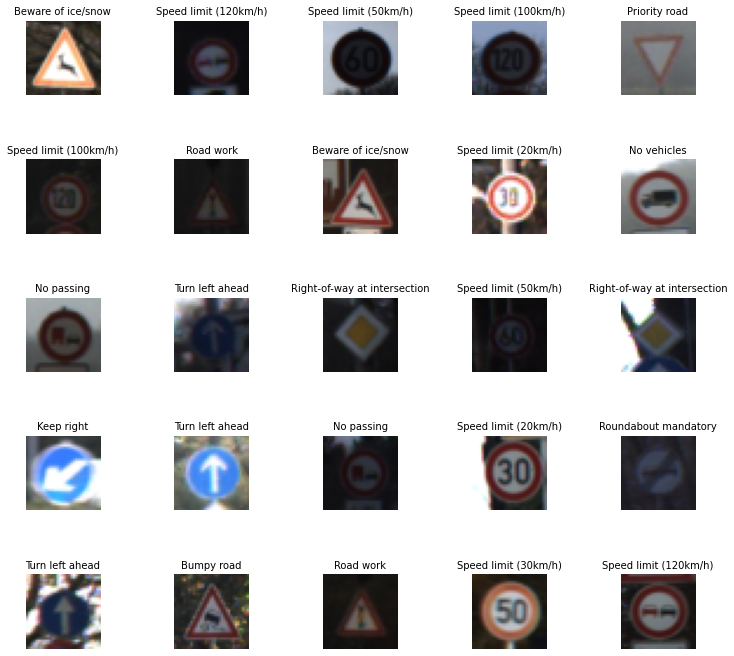

In [ ]:
i = np.random.randint(1, len(x_train)) 

w_grid = 5
l_grid = 5

fig, axes = plt.subplots(l_grid, w_grid, figsize=(12,12))
axes = axes.ravel()
n_training = len(x_train) 

for i in np.arange(0, w_grid*l_grid):
  index = np.random.randint(1,n_training) #Select a reandom integer between 1 and length of training data
  axes[i].imshow(x_train[index])
  axes[i].set_title(classes[y_train[index]], fontsize = 10 )
  axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4, wspace = 1 )

#Perform EDA

Image data shape = (32, 32, 3)
Number of classes = 43
Number of training examples = (34799, 32, 32, 3)
Number of testing examples = (12630, 32, 32, 3)
Number of validation examples =  (4410, 32, 32, 3)


Text(0.5, 1.0, 'Keep right')

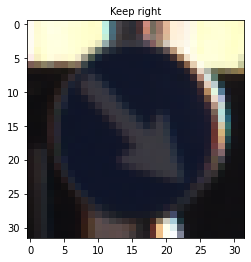

In [ ]:

# What's the shape of an traffic sign image?
# after resizing, train["sizes"] gives original shapes, which are different from one another
image_shape = train["features"][-1].shape

# How many unique classes/labels there are in the dataset?
n_classes = np.size(np.unique(train["labels"]))

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Number of training examples =", x_train.shape)
print("Number of testing examples =", x_test.shape)
print("Number of validation examples = ", x_valid.shape)

index = random.randint(0,len(x_train))
plt.imshow(x_train[index]);
plt.title(classes[y_train[index]+1], fontsize = 10 )


In [ ]:
#Plot the Class frequency 
def plot_class_distr():
  plt.figure(figsize=(8,6))
  plt.hist(y_train, n_classes, color='red', alpha=0.75, rwidth = 0.5)
  plt.xlabel('Class Label')
  plt.ylabel('No. of Occurrences')
  plt.title('Traffic Sign Instances Observed in Training Set')
  plt.axis([0, 43, 0, 2100])
  return plt

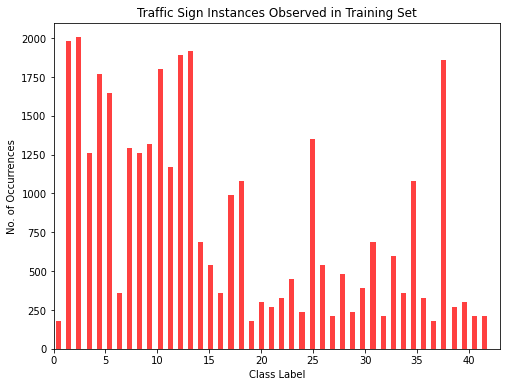

In [ ]:
plot_class_distr().show()

#Data Preprocessing

In [ ]:
x_train, y_train = shuffle(x_train, y_train)


In [ ]:
def rgb2gray(X):
    gray = np.dot(X, [0.299, 0.587, 0.114])
    gray = gray.reshape(len(X),32,32,1)
    return gray

#http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html
def standardize(X,test_set=False):
    if test_set:
        X -= np.mean(X_train)
        X /= np.std(X_train)
    else:
        X -= np.mean(X) # zero-center
        X /= np.std(X) # normalize
    return (X)

#Min Max Scaling -  http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-min-max-scaling
def normalize_scale(X):
    a = 0
    b = 1.0
    return a + X * (b-a) / 255

In [ ]:
# preprocessing pipeline
def preprocess_dataset(X,test_set=False):
    X = rgb2gray(X)
    X = normalize_scale(X)
    X = standardize(X,test_set)
    return X

In [ ]:
x_train_norm = preprocess_dataset(x_train)
x_valid_norm = preprocess_dataset(x_valid)
x_test_norm = preprocess_dataset(x_test)

In [ ]:
x_norm = np.concatenate((x_train_norm,x_valid_norm),axis=0)
y_norm = np.concatenate((y_train,y_valid),axis=0)

#Define Resuable Functions
1. Fit Model
2. Build Metrics
3. Confusion Matrix

In [ ]:
#Define Dataframe for Metrics

metrics_df = pd.DataFrame(columns=['Desc', 'Epochs', 'Train Loss', 'Train Accuracy %', 'Test Loss', 'Test Accuracy %',  'FitTime in Seconds'])

In [ ]:
def fit_model(model,epochs,X_train,X_valid,Y_train,Y_valid,verbose=1,earlystopping=False):
  start = datetime.datetime.now() 
  epochs = epochs
  if earlystopping == True:
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history =  model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=200,
                    validation_data=(X_valid,Y_valid),
                    verbose = verbose,
                    callbacks = [es]  )
  else:
    history = model.fit(X_train,
                     Y_train,
                    epochs=epochs,
                    batch_size=200,
                    validation_data=(X_valid,Y_valid),
                    verbose = verbose  )
  end = datetime.datetime.now()
  return history, (end - start).seconds, model

In [ ]:
def build_metrics(model,epochs,modeldesc,metrics_df,fittime,X_train,Y_train,X_test,Y_test):
  loss, accuracy = model.evaluate(X_test,Y_test)
  loss_train,accuracy_train = model.evaluate(X_train,Y_train)
  Newrow = {'Desc':modeldesc, 'Epochs':epochs, 'Train Loss':loss_train, 'Train Accuracy %':accuracy_train*100, 'Test Loss':loss, 'Test Accuracy %':accuracy*100,  'FitTime in Seconds':fittime}
  metrics_df = metrics_df.append(Newrow,ignore_index=True)
  return metrics_df

In [ ]:
def plot_metrics(history,epochs):
  #Plot the training and validation loss , accuracy
  losses = history.history['loss']
  val_losses = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(1, len(losses)+ 1) #Need to overwritte value in case of earlystopping
  print(len(losses),epochs)
  plt.figure(figsize=(12, 6))
  for i, metrics in enumerate(zip([losses, acc], [val_losses, val_acc], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(epochs, metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(epochs, metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  return plt

In [ ]:
def execute_model(model,modeldesc,epochs,metrics_df,X_train,X_valid,Y_train,Y_valid,X_test,Y_test,earlystopping=False,verbose=0):
  model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
  history,fit_time,model = fit_model(model,epochs,X_train,X_valid,Y_train,Y_valid,verbose,earlystopping)
  metrics_df = build_metrics(model,epochs,modeldesc, metrics_df,fit_time,X_train,Y_train,X_test,Y_test)
  plt = plot_metrics(history,epochs)
  return model,history,metrics_df,plt

In [ ]:
def Basemodel():
  CNN = models.Sequential()

  #Build Convolution Layer - Pooling Layer 

  CNN.add(layers.Conv2D(6, (5,5), activation = 'relu', input_shape = (32,32,1)))
  CNN.add(layers.AveragePooling2D())

  CNN.add(layers.Dropout(0.2))

  CNN.add(layers.Conv2D(16, (5,5), activation = 'relu'))
  CNN.add(layers.AveragePooling2D())

  CNN.add(layers.Flatten())

  CNN.add(layers.Dense(120, activation = 'relu'))
  CNN.add(layers.Dense(84, activation = 'relu'))
  CNN.add(layers.Dense(43,activation = 'softmax'))
  return CNN

#LeNet5 Architecture

In [25]:
def LesNetModel():
  #Instantiate an empty model
  model = models.Sequential()

  # C1 Convolutional Layer
  model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='same'))

  # S2 Pooling Layer
  model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))

  # C3 Convolutional Layer
  model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

  # S4 Pooling Layer
  model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

  # C5 Fully Connected Convolutional Layer
  model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
  #Flatten the CNN output so that we can connect it with fully connected layers
  model.add(layers.Flatten())

  # FC6 Fully Connected Layer
  model.add(layers.Dense(84, activation='tanh'))

  #Output Layer with softmax activation
  model.add(layers.Dense(43, activation='softmax'))

  return model


In [26]:
lesnet = LesNetModel( )
lesnet,history_lesnet,metrics_df,plt = execute_model(model = lesnet, modeldesc = 'LesNet',
                                                     epochs=500, metrics_df = metrics_df,
                                                     X_train = x_train_norm, Y_train = y_train,
                                                     X_valid = x_valid_norm, Y_valid = y_valid,
                                                     X_test =  x_test_norm, Y_test = y_test,
                                                     earlystopping=False, verbose=0)
plt.show()

NameError: ignored

In [ ]:
lesnet_es,history_lesnet_es,metrics_df,plt = execute_model(model = lesnet, modeldesc = 'LesNet-EarlyStopping',
                                                     epochs=100, metrics_df = metrics_df,
                                                     X_train = x_train_norm, Y_train = y_train,
                                                     X_valid = x_valid_norm, Y_valid = y_valid,
                                                     X_test =  x_test_norm, Y_test = y_test,
                                                     earlystopping=True, verbose=0)
plt.show()

In [ ]:
def LesNetModel_dropout():
  #Instantiate an empty model
  model = models.Sequential()

  # C1 Convolutional Layer
  model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(32,32,1), padding='same'))

  # S2 Pooling Layer
  model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
 
  #Dropout 
  model.add(layers.Dropout(0.2))

  # C3 Convolutional Layer
  model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

  # S4 Pooling Layer
  model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

  # C5 Fully Connected Convolutional Layer
  model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
  #Flatten the CNN output so that we can connect it with fully connected layers
  model.add(layers.Flatten())

  # FC6 Fully Connected Layer
  model.add(layers.Dense(84, activation='tanh'))

  #Output Layer with softmax activation
  model.add(layers.Dense(43, activation='softmax'))

  return model

In [ ]:
lesnet_dropout = LesNetModel_dropout( )
lesnet_reg,history_lesnet_reg,metrics_df,plt = execute_model(model = lesnet_dropout, modeldesc = 'LesNet-Reg-EarlyStopping',
                                                     epochs=100, metrics_df = metrics_df,
                                                     X_train = x_train_norm, Y_train = y_train,
                                                     X_valid = x_valid_norm, Y_valid = y_valid,
                                                     X_test =  x_test_norm, Y_test = y_test,
                                                     earlystopping=True, verbose=0)
plt.show()

In [ ]:
lesnet_dropout = LesNetModel_dropout( )
lesnet_reg,history_lesnet_reg,metrics_df,plt = execute_model(model = lesnet_dropout, modeldesc = 'LesNet-Reg',
                                                     epochs=500, metrics_df = metrics_df,
                                                     X_train = x_train_norm, Y_train = y_train,
                                                     X_valid = x_valid_norm, Y_valid = y_valid,
                                                     X_test =  x_test_norm, Y_test = y_test,
                                                     earlystopping=False, verbose=0)
plt.show()

In [ ]:
metrics_df.sort_values(by = 'Test Accuracy %', ascending=False)

#AlexNet - Required Image Preprocessing

In [18]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train ))
validation_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))


In [ ]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)
print("Validation data size:", validation_ds_size)

Training data size: 34799
Test data size: 12630
Validation data size: 4410


In [19]:
def process_images(image,label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 32x32 to 227x227
    image = tf.image.resize(image, (227,227))
    return image, label

In [20]:
#Data Preprocessing

train_ds = (train_ds
                  .map(process_images)
                  .shuffle(buffer_size=len(x_train))
                  .batch(batch_size=32, drop_remainder=True))
test_ds = (test_ds
                  .map(process_images)
                  .shuffle(buffer_size=len(x_test))
                  .batch(batch_size=32, drop_remainder=True))
validation_ds = (validation_ds
                  .map(process_images)
                  .shuffle(buffer_size=len(x_valid))
                  .batch(batch_size=32, drop_remainder=True))

In [21]:
def AlexNet():
  model = keras.models.Sequential([
      keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(43, activation='softmax')
  ])
  return model

In [22]:
BATCH_SIZE = 32
compute_steps_per_epoch = lambda x: int(math.floor(1. * x / BATCH_SIZE))
steps_per_epoch = compute_steps_per_epoch(len(x_train))
val_steps = compute_steps_per_epoch(len(x_valid))

In [23]:
checkpoint_path = "/content/drive/MyDrive/TafficSignsP/cp.ckpt"


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [24]:
alexnet = AlexNet()

alexnet.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
  
 
history_alexnet = alexnet.fit(train_ds,
          epochs=100,
          verbose = 1,
          validation_data=validation_ds,
          steps_per_epoch=steps_per_epoch,
          validation_steps=val_steps,
           callbacks=[cp_callback])

alexnet.save('/content/drive/MyDrive/TafficSignsP/my_model') 

alexmodel.save('/content/drive/MyDrive/TafficSignsP/my_model.h5') 

Epoch 1/100
1087/1087 [==============================] - ETA: 0s - loss: 3.7427 - accuracy: 0.0577
Epoch 00001: saving model to /content/drive/MyDrive/TafficSignsP/cp.ckpt
1087/1087 [==============================] - 42s 39ms/step - loss: 3.7427 - accuracy: 0.0577 - val_loss: 3.7459 - val_accuracy: 0.0545
Epoch 2/100
1087/1087 [==============================] - ETA: 0s - loss: 3.7426 - accuracy: 0.0577
Epoch 00002: saving model to /content/drive/MyDrive/TafficSignsP/cp.ckpt
1087/1087 [==============================] - 42s 38ms/step - loss: 3.7426 - accuracy: 0.0577 - val_loss: 3.7463 - val_accuracy: 0.0541
Epoch 3/100
1087/1087 [==============================] - ETA: 0s - loss: 3.7426 - accuracy: 0.0578
Epoch 00003: saving model to /content/drive/MyDrive/TafficSignsP/cp.ckpt
1087/1087 [==============================] - 41s 37ms/step - loss: 3.7426 - accuracy: 0.0578 - val_loss: 3.7459 - val_accuracy: 0.0545
Epoch 4/100
1087/1087 [==============================] - ETA: 0s - loss: 3.7426

NameError: ignored

In [ ]:
train_ds

<BatchDataset shapes: ((32, 227, 227, 3), (32,)), types: (tf.float32, tf.uint8)>

In [ ]:
# save the model to disk
filename = 'AlexNet_Model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
 
  plt = plot_metrics(history_alexnet,100)